## SIT-789 Task-8.2D

## Section-1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from pydub import AudioSegment
from pydub.utils import mediainfo
import librosa
import librosa.display
import os
import pickle

c:\program files\python37\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Read training file names and emotion labels

In [2]:
emotions = ['Calm', 'Happy', 'Sad', 'Angry']
path = 'EmotionSpeech/'
training_file_names = []
training_emotion_labels = []
for i in range(0, len(emotions)):
    sub_path = path + 'Train/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_emotion_labels += sub_emotion_labels

Set the default parameters for the task

In [3]:
sub_bands = [[300, 627], [628, 1060], [1061, 1633], [1634, 2393], [2394, 3400]]
n_freq = 16384
n_mel_freq = 3401
win_duration = 0.030
hop_duration = 0.015
num_frames = 200
window = 'hann'

Code for the SC feature extraction

In [4]:
def extract_sc(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = mel_spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        for f in range(num_frames):
            s = 0.00001
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                features[i][f] += k * spec_trunc[k][f]
                s += spec_trunc[k][f]
            
            features[i][f] /= s
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for SBW feature extraction

In [5]:
def extract_sbw(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = mel_spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        for f in range(num_frames):
            SC = 0
            s = 0.00001
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                SC += k * spec_trunc[k][f]                
                s += spec_trunc[k][f]
            SC /= s
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                features[i][f] += (k - SC) * (k - SC)  * spec_trunc[k][f]
            
            features[i][f] /= s
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for SBE feature extraction

In [32]:
def extract_sbe(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = mel_spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        for f in range(num_frames):
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                features[i][f] += spec_trunc[k][f]
                
    for f in range(num_frames):
        s = np.sum(features[:, f]) + 0.00001
        features[:, f] /= s
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for SFM feature extraction

In [8]:
def extract_sfm(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = mel_spec[:, i]
        
    features = np.ones((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        p = 1 / (sub_bands[i][1] - sub_bands[i][0] + 1)
        for f in range(num_frames):
            s = 0.00001
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                features[i][f] *= np.power(spec_trunc[k][f], p)
                s += spec_trunc[k][f]
            features[b][f] /= (p * s)
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for SCF feature extraction

In [27]:
def extract_scf(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = mel_spec[:, i]
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        p = 1 / (sub_bands[i][1] - sub_bands[i][0] + 1)
        for f in range(num_frames):
            s = 0.000001
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                s += spec_trunc[k][f]
            features[i][f] = np.max(spec_trunc[sub_bands[i][0]:sub_bands[i][1] + 1][f]) / (p * s)
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for RE feature extraction

In [4]:
def extract_re(audio_file):
    alpha = 3
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 1
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = abs(mel_spec[:, i])
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        for f in range(num_frames):
            m = 0.00001 + np.sum(spec_trunc[sub_bands[i][0]:sub_bands[i][1] + 1][f])
            s = 0.00001
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                s += np.power(spec_trunc[k][f] / m, alpha)
            features[i][f] = 1 / (1 - alpha) * np.log2(s)
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code for SE feature extraction

In [5]:
def extract_se(audio_file):
    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 1
    )
    
    spec_trunc = np.zeros((mel_spec.shape[0], num_frames), np.float32)
    for i in range(min(num_frames, mel_spec.shape[1])):
        spec_trunc[:, i] = abs(mel_spec[:, i])
        
    features = np.zeros((len(sub_bands), num_frames), np.float32)
    for i in range(len(sub_bands)):
        for f in range(num_frames):
            s = 0.00001 + np.sum(spec_trunc[sub_bands[i][0]:sub_bands[i][1] + 1][f])            
            for k in range(sub_bands[i][0], sub_bands[i][1] + 1):
                ratio = 0.00001 + spec_trunc[k][f] / s            
                features[i][f] -= ratio * np.log2(ratio)
        
    return np.reshape(features.T, features.shape[0] * features.shape[1])

Code to get the test file names and emotion labels

In [6]:
test_file_names = []
test_emotion_labels = []

for i in range(0, len(emotions)):
    sub_path = path + 'Test/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    test_file_names += sub_file_names
    test_emotion_labels += sub_emotion_labels

In [7]:
def get_features(file_list, func):
    extracted_features = []
    for file_name in file_list:
        extracted_features.append(func(file_name))
    return extracted_features

In [51]:
import json
train_features_sc = get_features(training_file_names, extract_sc)
test_features_sc = get_features(test_file_names, extract_sc)

In [70]:
import pickle
with open('train_features_sc.spc', 'wb') as outfile:
    pickle.dump(train_features_sc, outfile)
with open('test_features_sc.spc', 'wb') as outfile:
    pickle.dump(test_features_sc, outfile)

In [71]:
train_features_sbw = get_features(training_file_names, extract_sbw)
test_features_sbw = get_features(test_file_names, extract_sbw)

In [72]:
with open('train_features_sbw.spc', 'wb') as outfile:
    pickle.dump(train_features_sbw, outfile)
with open('test_features_sbw.spc', 'wb') as outfile:
    pickle.dump(test_features_sbw, outfile)

In [73]:
train_features_sbe = get_features(training_file_names, extract_sbe)
test_features_sbe = get_features(test_file_names, extract_sbe)
with open('train_features_sbe.spc', 'wb') as outfile:
    pickle.dump(train_features_sbe, outfile)
with open('test_features_sbe.spc', 'wb') as outfile:
    pickle.dump(test_features_sbe, outfile)

In [9]:
train_features_sfm = get_features(training_file_names, extract_sfm)
test_features_sfm = get_features(test_file_names, extract_sfm)
with open('train_features_sfm.spc', 'wb') as outfile:
    pickle.dump(train_features_sfm, outfile)
with open('test_features_sfm.spc', 'wb') as outfile:
    pickle.dump(test_features_sfm, outfile)

In [36]:
train_features_scf = get_features(training_file_names, extract_scf)
test_features_scf = get_features(test_file_names, extract_scf)
with open('train_features_scf.spc', 'wb') as outfile:
    pickle.dump(train_features_scf, outfile)
with open('test_features_scf.spc', 'wb') as outfile:
    pickle.dump(test_features_scf, outfile)

In [8]:
train_features_re = get_features(training_file_names, extract_re)
test_features_re = get_features(test_file_names, extract_re)
with open('train_features_re.spc', 'wb') as outfile:
    pickle.dump(train_features_re, outfile)
with open('test_features_re.spc', 'wb') as outfile:
    pickle.dump(test_features_re, outfile)

In [9]:
train_features_se = get_features(training_file_names, extract_se)
test_features_se = get_features(test_file_names, extract_se)
with open('train_features_se.spc', 'wb') as outfile:
    pickle.dump(train_features_se, outfile)
with open('test_features_se.spc', 'wb') as outfile:
    pickle.dump(test_features_se, outfile)

## Section-2

In [10]:
def get_predicted_labels(classifier, test_features_list):
    predicted_emotion_labels = []
    for test_feature in test_features_list:
        predicted_emotion_label = classifier.predict([test_feature])
        predicted_emotion_labels.append(predicted_emotion_label)
    return predicted_emotion_labels

In [11]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def get_classification_report(predicted_emotion_labels):    
    cm = confusion_matrix(test_emotion_labels, predicted_emotion_labels)
    print('Confusion Matrix', cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm.diagonal())
    
    acc = np.sum(cm.diagonal()) / np.sum(cm)
    print('Overall accuracy: {} %'.format(acc*100))
    
    from sklearn.metrics import f1_score
    print('F1-Score', f1_score(test_emotion_labels, predicted_emotion_labels, average='macro'))
    
    print(classification_report(test_emotion_labels, predicted_emotion_labels))
    print('Accuracy Score', accuracy_score(test_emotion_labels, predicted_emotion_labels))

In [12]:
from sklearn import svm
def train_svm_classifier(training_features):    
    svm_classifier = svm.SVC(C = 10, #see slide 32 in week 4 lecture slides
                            kernel = 'linear') #see slide 35 in week 4 lecture slides
    svm_classifier.fit(training_features, training_emotion_labels)
    
    return svm_classifier

In [13]:
from sklearn.ensemble import AdaBoostClassifier

def train_adaboost_classifier(training_features):
    adb_classifier = AdaBoostClassifier(n_estimators = 200,
                                        random_state = 0)
    
    adb_classifier.fit(training_features, training_emotion_labels)
    
    return adb_classifier

## 1. Spectral Centroid (SC)

In [21]:
with open('train_features_sc.spc', 'rb') as f:
    train_features_sc = pickle.load(f)
with open('test_features_sc.spc', 'rb') as f:
    test_features_sc = pickle.load(f)    

In [20]:
svm_classifier = train_svm_classifier(train_features_sc)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_sc)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[17  5  5  5]
 [ 6 14  9  3]
 [ 8 13  6  5]
 [ 6  4  6 16]]
[0.53125 0.4375  0.1875  0.5    ]
Overall accuracy: 41.40625 %
              precision    recall  f1-score   support

           0       0.46      0.53      0.49        32
           1       0.39      0.44      0.41        32
           2       0.23      0.19      0.21        32
           3       0.55      0.50      0.52        32

    accuracy                           0.41       128
   macro avg       0.41      0.41      0.41       128
weighted avg       0.41      0.41      0.41       128

Accuracy Score 0.4140625


In [21]:
ada_classifier = train_adaboost_classifier(train_features_sc)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_sc)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[10 12  8  2]
 [ 0 17  9  6]
 [ 0 10 15  7]
 [ 4 12 11  5]]
[0.3125  0.53125 0.46875 0.15625]
Overall accuracy: 36.71875 %
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        32
           1       0.33      0.53      0.41        32
           2       0.35      0.47      0.40        32
           3       0.25      0.16      0.19        32

    accuracy                           0.37       128
   macro avg       0.41      0.37      0.36       128
weighted avg       0.41      0.37      0.36       128

Accuracy Score 0.3671875


## 2. Spectral Bandwidth (SBW)

In [22]:
with open('train_features_sbw.spc', 'rb') as f:
    train_features_sbw = pickle.load(f)
with open('test_features_sbw.spc', 'rb') as f:
    test_features_sbw = pickle.load(f)    

In [23]:
svm_classifier = train_svm_classifier(train_features_sbw)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_sbw)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[16  3  9  4]
 [12 13  1  6]
 [ 7  3 18  4]
 [ 4  9  6 13]]
[0.5     0.40625 0.5625  0.40625]
Overall accuracy: 46.875 %
              precision    recall  f1-score   support

           0       0.41      0.50      0.45        32
           1       0.46      0.41      0.43        32
           2       0.53      0.56      0.55        32
           3       0.48      0.41      0.44        32

    accuracy                           0.47       128
   macro avg       0.47      0.47      0.47       128
weighted avg       0.47      0.47      0.47       128

Accuracy Score 0.46875


In [24]:
ada_classifier = train_adaboost_classifier(train_features_sbw)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_sbw)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[14  9  2  7]
 [ 8  8  6 10]
 [ 6  8  6 12]
 [ 5  5  3 19]]
[0.4375  0.25    0.1875  0.59375]
Overall accuracy: 36.71875 %
              precision    recall  f1-score   support

           0       0.42      0.44      0.43        32
           1       0.27      0.25      0.26        32
           2       0.35      0.19      0.24        32
           3       0.40      0.59      0.48        32

    accuracy                           0.37       128
   macro avg       0.36      0.37      0.35       128
weighted avg       0.36      0.37      0.35       128

Accuracy Score 0.3671875


## 3. Spectral Band Energy (SBE)

In [25]:
with open('train_features_sbe.spc', 'rb') as f:
    train_features_sbe = pickle.load(f)
with open('test_features_sbe.spc', 'rb') as f:
    test_features_sbe = pickle.load(f)    

In [26]:
svm_classifier = train_svm_classifier(train_features_sbe)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_sbe)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[25  0  1  6]
 [ 8 17  1  6]
 [ 6 11  8  7]
 [ 5  3  2 22]]
[0.78125 0.53125 0.25    0.6875 ]
Overall accuracy: 56.25 %
              precision    recall  f1-score   support

           0       0.57      0.78      0.66        32
           1       0.55      0.53      0.54        32
           2       0.67      0.25      0.36        32
           3       0.54      0.69      0.60        32

    accuracy                           0.56       128
   macro avg       0.58      0.56      0.54       128
weighted avg       0.58      0.56      0.54       128

Accuracy Score 0.5625


In [27]:
ada_classifier = train_adaboost_classifier(train_features_sbe)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_sbe)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[13  2  7 10]
 [ 6 12 10  4]
 [ 4  6 10 12]
 [ 6  3  3 20]]
[0.40625 0.375   0.3125  0.625  ]
Overall accuracy: 42.96875 %
              precision    recall  f1-score   support

           0       0.45      0.41      0.43        32
           1       0.52      0.38      0.44        32
           2       0.33      0.31      0.32        32
           3       0.43      0.62      0.51        32

    accuracy                           0.43       128
   macro avg       0.43      0.43      0.42       128
weighted avg       0.43      0.43      0.42       128

Accuracy Score 0.4296875


## 4. Spectral Flatness Measure (SFM)

In [8]:
with open('train_features_sfm.spc', 'rb') as f:
    train_features_sfm = pickle.load(f)
with open('test_features_sfm.spc', 'rb') as f:
    test_features_sfm = pickle.load(f)    

In [15]:
svm_classifier = train_svm_classifier(train_features_sfm)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_sfm)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[21  3  8  0]
 [ 8 17  5  2]
 [ 6 10 13  3]
 [ 6 15  4  7]]
[0.65625 0.53125 0.40625 0.21875]
Overall accuracy: 45.3125 %
              precision    recall  f1-score   support

           0       0.51      0.66      0.58        32
           1       0.38      0.53      0.44        32
           2       0.43      0.41      0.42        32
           3       0.58      0.22      0.32        32

    accuracy                           0.45       128
   macro avg       0.48      0.45      0.44       128
weighted avg       0.48      0.45      0.44       128

Accuracy Score 0.453125


In [16]:
ada_classifier = train_adaboost_classifier(train_features_sfm)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_sfm)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[18  2 12  0]
 [ 7 16  6  3]
 [ 5  8 16  3]
 [ 2  9  8 13]]
[0.5625  0.5     0.5     0.40625]
Overall accuracy: 49.21875 %
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        32
           1       0.46      0.50      0.48        32
           2       0.38      0.50      0.43        32
           3       0.68      0.41      0.51        32

    accuracy                           0.49       128
   macro avg       0.52      0.49      0.50       128
weighted avg       0.52      0.49      0.50       128

Accuracy Score 0.4921875


## 5. Spectral Crest Factor (SCF)

In [37]:
import pickle
with open('train_features_scf.spc', 'rb') as f:
    train_features_scf = pickle.load(f)
with open('test_features_scf.spc', 'rb') as f:
    test_features_scf = pickle.load(f)    

In [42]:
svm_classifier = train_svm_classifier(train_features_scf)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_scf)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]
 [ 0  0  0 32]]
[0. 0. 0. 1.]
Overall accuracy: 25.0 %
F1-Score 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        32
           3       0.25      1.00      0.40        32

    accuracy                           0.25       128
   macro avg       0.06      0.25      0.10       128
weighted avg       0.06      0.25      0.10       128

Accuracy Score 0.25


c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
ada_classifier = train_adaboost_classifier(train_features_scf)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_scf)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[17  7  5  3]
 [ 3 17  9  3]
 [ 3 11 17  1]
 [10  5 11  6]]
[0.53125 0.53125 0.53125 0.1875 ]
Overall accuracy: 44.53125 %
              precision    recall  f1-score   support

           0       0.52      0.53      0.52        32
           1       0.42      0.53      0.47        32
           2       0.40      0.53      0.46        32
           3       0.46      0.19      0.27        32

    accuracy                           0.45       128
   macro avg       0.45      0.45      0.43       128
weighted avg       0.45      0.45      0.43       128

Accuracy Score 0.4453125


## 6. Renyi Entropy (RE)

In [14]:
with open('train_features_re.spc', 'rb') as f:
    train_features_re = pickle.load(f)
with open('test_features_re.spc', 'rb') as f:
    test_features_re = pickle.load(f)    

In [15]:
svm_classifier = train_svm_classifier(train_features_re)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_re)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[20  6  5  1]
 [ 8 13  6  5]
 [ 7 11 10  4]
 [14 10  2  6]]
[0.625   0.40625 0.3125  0.1875 ]
Overall accuracy: 38.28125 %
F1-Score 0.3671436588103255
              precision    recall  f1-score   support

           0       0.41      0.62      0.49        32
           1       0.33      0.41      0.36        32
           2       0.43      0.31      0.36        32
           3       0.38      0.19      0.25        32

    accuracy                           0.38       128
   macro avg       0.39      0.38      0.37       128
weighted avg       0.39      0.38      0.37       128

Accuracy Score 0.3828125


In [25]:
ada_classifier = train_adaboost_classifier(train_features_re)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_re)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[11  0 12  9]
 [ 3  0 17 12]
 [ 2  0 22  8]
 [ 4  0 18 10]]
[0.34375 0.      0.6875  0.3125 ]
Overall accuracy: 33.59375 %
F1-Score 0.2851026570696073
              precision    recall  f1-score   support

           0       0.55      0.34      0.42        32
           1       0.00      0.00      0.00        32
           2       0.32      0.69      0.44        32
           3       0.26      0.31      0.28        32

    accuracy                           0.34       128
   macro avg       0.28      0.34      0.29       128
weighted avg       0.28      0.34      0.29       128

Accuracy Score 0.3359375


c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 7. Shannon Entropy (SE)

In [17]:
with open('train_features_se.spc', 'rb') as f:
    train_features_se = pickle.load(f)
with open('test_features_se.spc', 'rb') as f:
    test_features_se = pickle.load(f)    

In [18]:
svm_classifier = train_svm_classifier(train_features_se)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, test_features_se)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[20  3  5  4]
 [ 7 10  4 11]
 [15  6  5  6]
 [12  3  6 11]]
[0.625   0.3125  0.15625 0.34375]
Overall accuracy: 35.9375 %
F1-Score 0.3428860854369575
              precision    recall  f1-score   support

           0       0.37      0.62      0.47        32
           1       0.45      0.31      0.37        32
           2       0.25      0.16      0.19        32
           3       0.34      0.34      0.34        32

    accuracy                           0.36       128
   macro avg       0.35      0.36      0.34       128
weighted avg       0.35      0.36      0.34       128

Accuracy Score 0.359375


In [19]:
ada_classifier = train_adaboost_classifier(train_features_se)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, test_features_se)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[18  8  5  1]
 [ 4 11 11  6]
 [ 5 12 14  1]
 [ 9  8  5 10]]
[0.5625  0.34375 0.4375  0.3125 ]
Overall accuracy: 41.40625 %
F1-Score 0.41429534184916345
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        32
           1       0.28      0.34      0.31        32
           2       0.40      0.44      0.42        32
           3       0.56      0.31      0.40        32

    accuracy                           0.41       128
   macro avg       0.43      0.41      0.41       128
weighted avg       0.43      0.41      0.41       128

Accuracy Score 0.4140625


## 8. Combination SE & SC

In [22]:
new_feature_train = []
new_feature_test = []
n_samples = 128

for i in range(128):
    new_feature_train.append(np.concatenate([train_features_sc[i], train_features_se[i]]))
    new_feature_test.append(np.concatenate([test_features_sc[i], test_features_se[i]]))

In [23]:
svm_classifier = train_svm_classifier(new_feature_train)
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, new_feature_test)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[18  5  5  4]
 [ 6 14  9  3]
 [ 8 13  6  5]
 [ 6  4  6 16]]
[0.5625 0.4375 0.1875 0.5   ]
Overall accuracy: 42.1875 %
F1-Score 0.41657007630638465
              precision    recall  f1-score   support

           0       0.47      0.56      0.51        32
           1       0.39      0.44      0.41        32
           2       0.23      0.19      0.21        32
           3       0.57      0.50      0.53        32

    accuracy                           0.42       128
   macro avg       0.42      0.42      0.42       128
weighted avg       0.42      0.42      0.42       128

Accuracy Score 0.421875


In [24]:
ada_classifier = train_adaboost_classifier(new_feature_train)
predicted_emotion_labels_ada = get_predicted_labels(ada_classifier, new_feature_test)
get_classification_report(predicted_emotion_labels_ada)

Confusion Matrix [[14  5 10  3]
 [ 2 11 18  1]
 [ 1  8 19  4]
 [ 5  8 13  6]]
[0.4375  0.34375 0.59375 0.1875 ]
Overall accuracy: 39.0625 %
F1-Score 0.38404539049919484
              precision    recall  f1-score   support

           0       0.64      0.44      0.52        32
           1       0.34      0.34      0.34        32
           2       0.32      0.59      0.41        32
           3       0.43      0.19      0.26        32

    accuracy                           0.39       128
   macro avg       0.43      0.39      0.38       128
weighted avg       0.43      0.39      0.38       128

Accuracy Score 0.390625


## Mel-Spectrogram

In [10]:
def plot_spectogram(audio_file):

    speech = AudioSegment.from_wav(audio_file) #Read audio data from file
    x = speech.get_array_of_samples() #samples x(t)
    x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mel_spec = librosa.feature.melspectrogram(
        np.float32(x),
        hop_length = int(x_sr * hop_duration),
        n_fft = n_freq,
        n_mels = n_mel_freq,
        power = 2
    )

    plt.figure(figsize = (15, 5))
    #convert the amplitude to decibels, just for illustration purpose
    mel_spec_sdb = librosa.amplitude_to_db(abs(mel_spec))
    librosa.display.specshow(
                                #spectrogram
                                mel_spec_sdb,

                                #sampling rate
                                sr = x_sr,

                                #label for horizontal axis
                                x_axis = 'time',

                                #presentation scale
                                y_axis = 'linear',

                                #hop_lenght
                                hop_length = int(x_sr * hop_duration)
                            )

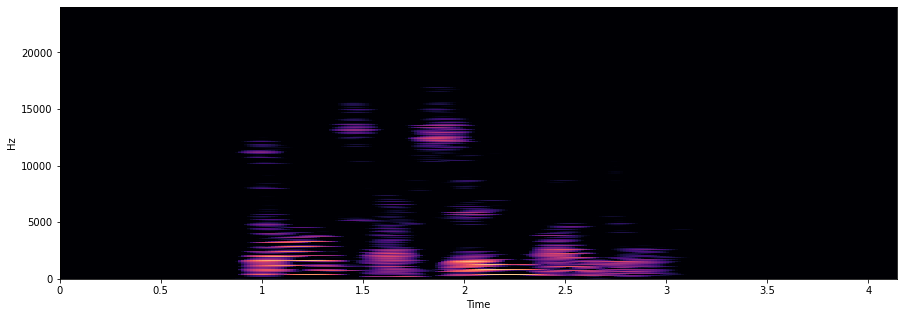

In [23]:
plot_spectogram('EmotionSpeech/Test/Calm/03-01-02-01-02-01-05.wav')

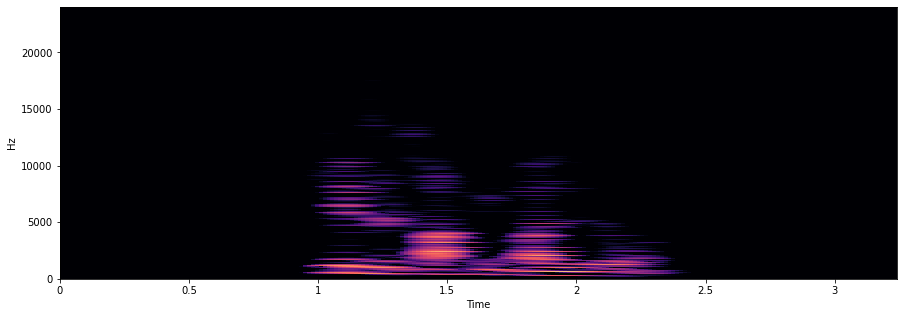

In [24]:
plot_spectogram('EmotionSpeech/Test/Happy/03-01-03-01-01-02-05.wav')

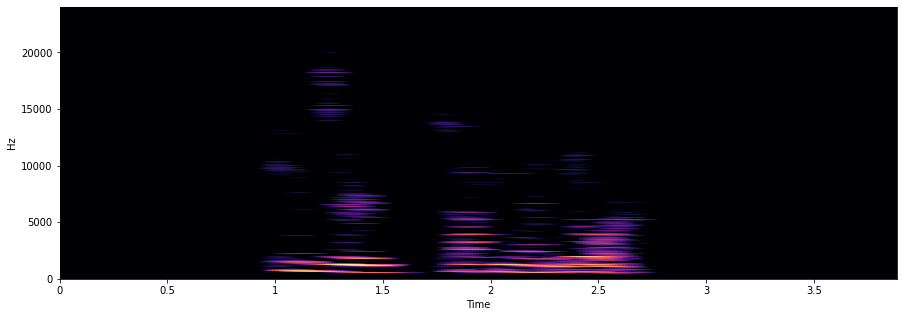

In [25]:
plot_spectogram('EmotionSpeech/Test/Sad/03-01-04-01-01-02-08.wav')

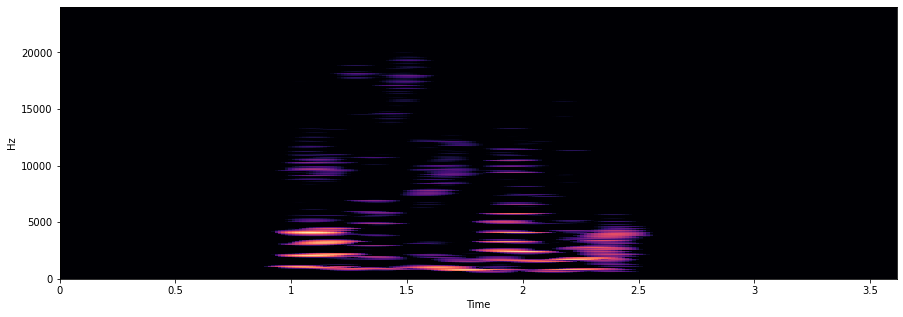

In [26]:
plot_spectogram('EmotionSpeech/Test/Angry/03-01-05-02-02-01-08.wav')